### Setup


The following few sections define packages used and set the environenment (you can ignore them)

In [1]:
# First off - load all python libraries we are going to need
import pandas as pd
import numpy as np
import os
#import plotly.plotly as py
#import plotly.graph_objs as go


from google.colab import auth
from google.cloud import bigquery
from google.colab import files

import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure


from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifier
!pip install regressors
from regressors import stats    


from sklearn.impute import SimpleImputer

from sklearn import metrics

import statsmodels.api as sm

!pip install pygam
from pygam import GAM, s, l , te ,LogisticGAM, LinearGAM

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

!pip install zepid
import zepid as zp

#import plotly
#plotly.tools.set_credentials_file(username='harounchahed', api_key='ZHypTc119csyz5p0xWet')

  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12374 sha256=5d14f922d9800446cc0b84f386fef444e07ea059ab76f28ef14160af0d05f80c
  Stored in directory: /root/.cache/pip/wheels/b2/89/fc/7867f77234d0033395f7ad9814f245b337139acaa06b085aa2
Successfully built regressors
     |████████████████████████████████| 1.8MB 5.0MB/s 
     |████████████████████████████████| 481kB 5.1MB/s 
ERROR: zepid 0.8.1 has requirement matplotlib<3.1,>=2.0, but you'll have matplotlib 3.1.3 which is incompatible.


In [0]:
auth.authenticate_user() #This will allow you to authenticate access to BigQuery4/rwDcMzFm8oGoxefjkisvhYNHOGbb11AmM1WbgDorhC0DBQNExxFg1yI

In [0]:
#This is a method that executes a desired SQL query on the database
project_id='ync-capstones'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

In [4]:
# Now load the data. In general you'd load the whole set of notes but that would take
# several minutes so for this example we're just going to use a subset
#notes = pd.read_csv('D.csv')
cohort = run_query('''
    select * 
    from `NMB.COHORT_BASELINE_P2`
    ''')

PF_raw = run_query('''
    select * 
    from `NMB.TIME_DEP_PF`
    ''')

Treamtment_raw = run_query('''
    select * 
    from `NMB.TIME_DEP_TR`
    ''')

/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


# Data Cleaning

## Cohort

In [0]:
cohort = cohort.set_index(['subject_id',	'hadm_id',	'icustay_id'], drop = True)

In [0]:
cohort.mv_starttime = pd.to_datetime(cohort.mv_starttime)
cohort.mv_endtime = pd.to_datetime(cohort.mv_endtime)
cohort.dod = pd.to_datetime(cohort.dod)

In [7]:
cohort

,,,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,,,
10852,139654,253340,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.10,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0
27172,183106,209167,155.00000,2111-09-06 01:00:00,2111-09-12 12:00:00,76.25000,12.0,55.0,NaT,16.8144,NaN,177.80,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA,0,54,17,1,1
42071,186278,266722,24.50000,2117-08-05 16:00:00,2117-08-06 16:30:00,101.66667,10.0,46.0,NaT,6.3212,85.30,180.00,26.3,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,ENGL,CATHOLIC,MARRIED,PATIENT DECLINED TO ANSWER,STATUS POST CARDIAC ARREST\CARDIAC CATHETERIZA...,0,34,0,0,0
48925,127507,260855,183.66667,2129-01-22 16:20:00,2129-01-30 08:00:00,71.00000,18.0,68.0,NaT,19.2946,113.40,NaN,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,NOT SPECIFIED,MARRIED,WHITE,SKULL FRACTURE; HEAD BLEED,0,51,13,0,1
51443,195487,214313,153.25000,2124-03-06 08:00:00,2124-03-12 16:15:00,110.00000,15.0,57.0,2124-11-07,16.8966,201.85,177.80,63.9,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,NOT SPECIFIED,SINGLE,WHITE,ALTERED MENTAL STATUS,0,38,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42860,160594,219786,5.48333,2113-01-23 19:00:00,2113-01-24 00:29:00,79.00000,5.0,62.0,NaT,1.2864,88.40,180.00,27.3,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,MITRAL VALVE STENOSIS; SHORTNESS OF BREATH\LEF...,0,33,0,0,1
6025,184173,233970,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.00,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1
14858,191758,211210,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.60,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1


In [8]:
cohort.shape # number of patiens
# Sanity check: cohort.groupby(['subject_id', 'hadm_id','icustay_id']).size().count() 

(3820, 23)

In [9]:
# This code fixes few ages that are assigned an age >300 by mistake. We replace these ages with the average age of the dataset.
cohort.loc[cohort.age >= 300, 'age'] = 89

/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [0]:
# this code fixes removes unrealistic PEEP values 
cohort = cohort.drop(cohort[cohort.max_peep > 50].index)

In [0]:
cohort["mortality"] = np.where(cohort.dod.notnull(), 1 , 0)

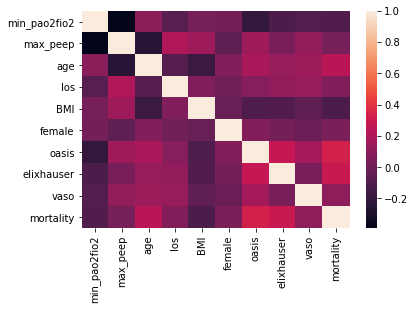

In [12]:
for_cov = cohort[[	"min_pao2fio2",	"max_peep",	"age"	, "los"	, 
                      "BMI"	, "admission_type"	, "admission_location",	
                      "religion" ,	"marital_status",	"ethnicity",	"diagnosis"	,	"female"	, "oasis",
                      "elixhauser",	"vaso",	"mortality"]]
corr = for_cov.corr()
corr_fig = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
#corr_fig.figure.savefig("corr_fig.pdf", bbox_inches='tight', dpi=300)
#files.download("corr_fig.pdf") 

In [13]:
# Dataframe containing only severity and comorbidity scores.
illness = cohort[['oasis', 'elixhauser']]

# Correlation coefficients 
illness.corr()

,oasis,elixhauser
oasis,1.000000,0.277414
elixhauser,0.277414,1.000000


## PF ratios

In [0]:
PF_raw.mv_starttime = pd.to_datetime(PF_raw.mv_starttime)
PF_raw.mv_endtime = pd.to_datetime(PF_raw.mv_endtime)
PF_raw.pf_charttime = pd.to_datetime(PF_raw.pf_charttime)

In [15]:
PF_raw

,subject_id,hadm_id,icustay_id,mv_durations_hours,mv_starttime,mv_endtime,pao2fio2,pf_charttime
0,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,176.66667,2149-11-10 00:42:00
1,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,150.00000,2149-11-10 08:04:00
2,9,150750,220597,118.33333,2149-11-09 18:40:00,2149-11-14 17:00:00,125.00000,2149-11-09 22:47:00
3,32,175413,295037,12.75000,2170-04-04 21:45:00,2170-04-05 10:30:00,147.00000,2170-04-04 22:54:00
4,32,175413,295037,12.75000,2170-04-04 21:45:00,2170-04-05 10:30:00,222.50000,2170-04-05 06:19:00
...,...,...,...,...,...,...,...,...
19492,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,130.00000,2181-01-30 04:32:00
19493,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,136.25000,2181-01-29 20:08:00
19494,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,135.00000,2181-01-30 09:01:00
19495,99985,176670,279638,216.76667,2181-01-29 13:14:00,2181-02-07 14:00:00,46.00000,2181-01-29 13:57:00


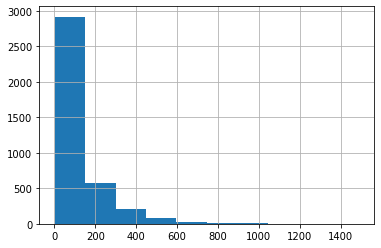

In [16]:
cohort.mv_durations_hours.hist()

In [17]:
PF_raw.subject_id.count() # of PF ratio observations taken within the mechanical ventilation period of our patie

19497

In [18]:
PF_raw.groupby(['subject_id', 'hadm_id','icustay_id']).size().count() # 3820 of 3820 have at least one PF ratio measured

3820

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a58061cc0>]],
      dtype=object)

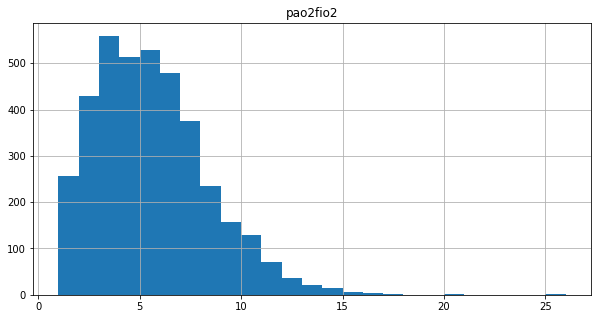

In [19]:
PF_raw[['subject_id', 'hadm_id','icustay_id', 'pao2fio2']].groupby(['subject_id', 'hadm_id','icustay_id']).count().hist(figsize = (10,5), bins=25)

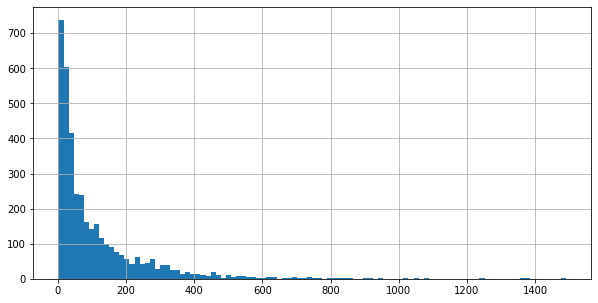

In [20]:
cohort.mv_durations_hours.hist(figsize = (10,5), bins=100)

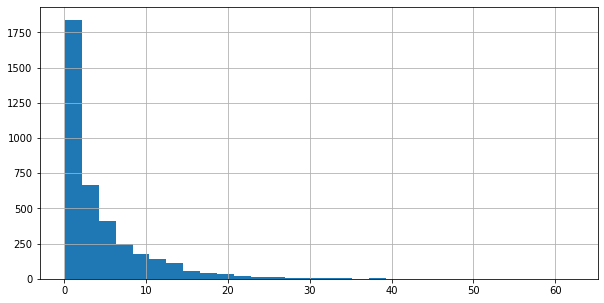

In [21]:
cohort.mv_durations_hours.divide(24).hist(figsize = (10,5), bins=30, grid = 1)

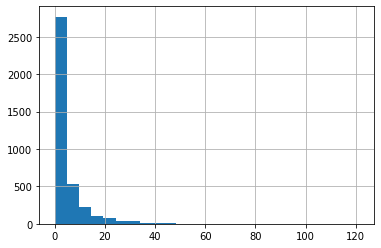

In [22]:
freq_of_PF = np.array(PF_raw.groupby(['subject_id', 'hadm_id','icustay_id']).size()) / cohort.mv_durations_hours.divide(24) 
freq_of_PF.hist(bins = 25)

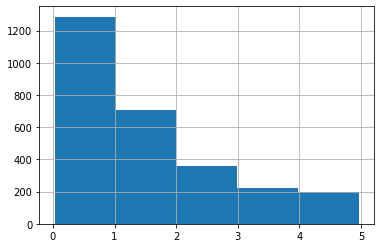

In [23]:
freq_of_PF[freq_of_PF < 5].hist(bins = 5)

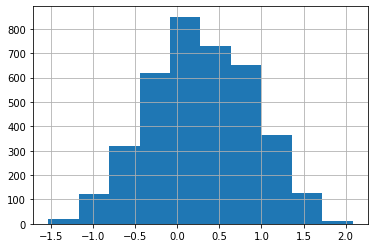

In [24]:
freq_of_PF_log = np.log10(freq_of_PF)
freq_of_PF_log.hist(bins = 10)
# 10^{-0.5} = 0.3 time per day
# 10^1 = 10 times per days

### Treatment

In [0]:
Treamtment_raw.mv_starttime = pd.to_datetime(Treamtment_raw.mv_starttime)
Treamtment_raw.mv_endtime = pd.to_datetime(Treamtment_raw.mv_endtime)
Treamtment_raw.NMBA_timestamp = pd.to_datetime(Treamtment_raw.NMBA_timestamp)

In [26]:
Treamtment_raw.head

<bound method NDFrame.head of        subject_id  hadm_id  ...  NMBA_amount      NMBA_timestamp
0             213   179315  ...     4.701333 2122-02-15 03:40:00
1             213   179315  ...     0.000000 2122-02-15 05:00:00
2             213   179315  ...          NaN 2122-02-15 03:00:00
3             213   179315  ...          NaN 2122-02-15 03:40:00
4             213   179315  ...     7.052000 2122-02-15 03:00:00
...           ...      ...  ...          ...                 ...
37598       99472   161362  ...    -0.286566 2193-12-27 05:15:00
37599       99726   186684  ...   100.000000 2200-11-25 13:08:00
37600       99726   186684  ...   100.000000 2200-11-24 20:28:00
37601       99726   186684  ...    99.920010 2200-11-25 13:08:00
37602       99726   186684  ...    30.900000 2200-11-26 05:47:00

[37603 rows x 8 columns]>

In [27]:
Treamtment_raw.icustay_id.count() # of NMBA doses givent within the mechanical ventilation period of our patients

37603

In [28]:
Treamtment_raw.groupby(['subject_id', 'hadm_id','icustay_id']).size().count() # 468 have been given NMBAS

468

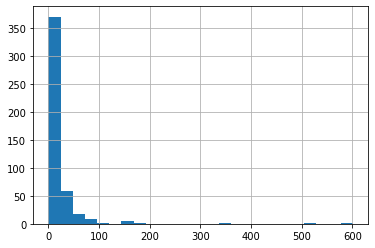

In [29]:
tr_grouped = Treamtment_raw.groupby(['subject_id', 'hadm_id','icustay_id']).size()
freq_of_TR = np.array(tr_grouped) / cohort.mv_durations_hours.loc[tr_grouped.index].divide(24) 
freq_of_TR.hist(bins = 25)

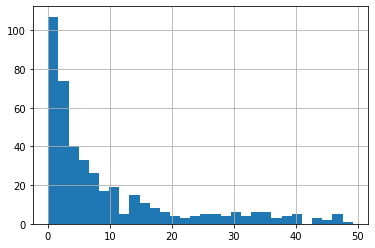

In [30]:
freq_of_TR[freq_of_TR < 50].hist(bins = 30)

In [31]:
freq_of_TR[freq_of_TR < 1].count() # number of people who are treated less than once a day

67

# IPTW

## Example 1

Example of patient who did not take drug

In [0]:
this_index = (9,	150750,	220597)

In [0]:
dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index].date(),
              end = cohort.mv_endtime.loc[this_index].date(),
              freq = 'D' )
date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
date['pao2fio2'] = np.nan
date['tr_t_min_1'] = np.zeros(len(dates_index))
date['tr_t'] = np.zeros(len(dates_index))
date['death_t'] = np.zeros(len(dates_index))

In [0]:
# fill the PF ratios
for index ,row  in PF_raw.loc[PF_raw.icustay_id== this_index[2]].iterrows():
  PF_date = row.pf_charttime.date()
  if PF_date in dates_index: 
    date.pao2fio2.loc[PF_date] = row.pao2fio2

In [0]:
# fill the treatment history 
for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
  tr_date = row.pf_charttime.date()
  if tr_date in dates_index: 
    date.tr_t.loc[PF_date] = 1
    date['tr_t-1'].loc[PF_date] = 1

In [0]:
# Fill in death date 
if pd.notnull(cohort.loc[this_index].dod.date()): 
  if cohort.loc[this_index].dod.date() in dates_index:
    date.death_t.loc[cohort.loc[this_index].dod.date()] = 1

In [37]:
date

,pao2fio2,tr_t_min_1,tr_t,death_t
MV_date,,,,
2149-11-09,125.0,0.0,0.0,0.0
2149-11-10,150.0,0.0,0.0,0.0
2149-11-11,NaN,0.0,0.0,0.0
2149-11-12,NaN,0.0,0.0,0.0
2149-11-13,NaN,0.0,0.0,0.0
2149-11-14,NaN,0.0,0.0,1.0


In [0]:
# date_imputed = date.fillna(date.mean())
# date_imputed

In [0]:
# y, X = dmatrices('tr_t ~  pao2fio2 + tr_t-1', data=date_imputed, return_type='dataframe')
# logit_model=sm.Logit(y,X)
# result=logit_model.fit()
# print(result.summary())

## Example 2 

Example of patient who took drug

In [0]:
this_index = (250	,124271	,205951)

In [0]:
dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index].date(),
              end = cohort.mv_endtime.loc[this_index].date(),
              freq = 'D' )
date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
date['pao2fio2'] = np.nan
date['tr_t_min_1'] = np.zeros(len(dates_index))
date['tr_t'] = np.zeros(len(dates_index))
date['death_t'] = np.zeros(len(dates_index))

In [0]:
# fill the PF ratios
for index ,row  in PF_raw.loc[PF_raw.icustay_id== this_index[2]].iterrows():
  PF_date = row.pf_charttime.date()
  if PF_date in dates_index: 
    date.pao2fio2.loc[PF_date] = row.pao2fio2

In [0]:
# fill the treatment history 
for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
  tr_date = row.NMBA_timestamp.date()
  if tr_date in dates_index: 
    date['tr_t'].loc[tr_date] = 1
    next_day = (tr_date + pd.DateOffset(1)).date()
    if next_day in dates_index:
      date['tr_t_min_1'].loc[next_day] = 1

In [0]:
# Fill in death date 
if pd.notnull(cohort.loc[this_index].dod.date()): 
  if cohort.loc[this_index].dod.date() in dates_index:
    date.death_t.loc[cohort.loc[this_index].dod.date()] = 1

In [45]:
date

,pao2fio2,tr_t_min_1,tr_t,death_t
MV_date,,,,
2188-11-12,NaN,0.0,0.0,0.0
2188-11-13,86.0,0.0,1.0,0.0
2188-11-14,NaN,1.0,1.0,0.0
2188-11-15,NaN,1.0,0.0,0.0
2188-11-16,NaN,0.0,0.0,0.0
2188-11-17,NaN,0.0,0.0,0.0
2188-11-18,NaN,0.0,0.0,0.0
2188-11-19,NaN,0.0,0.0,0.0
2188-11-20,NaN,0.0,0.0,0.0


## Example 3

Example of other patient who took the drug

In [0]:
this_index = (3417,	101256,	268184)

In [0]:
dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index].date(),
              end = cohort.mv_endtime.loc[this_index].date(),
              freq = 'D' )
date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
date['pao2fio2'] = np.nan
date['tr_t_min_1'] = np.zeros(len(dates_index))
date['tr_t'] = np.zeros(len(dates_index))
date['death_t'] = np.zeros(len(dates_index))

In [0]:
# fill the PF ratios
for index ,row  in PF_raw.loc[PF_raw.icustay_id== this_index[2]].iterrows():
  PF_date = row.pf_charttime.date()
  if PF_date in dates_index: 
    date.pao2fio2.loc[PF_date] = row.pao2fio2

In [0]:
# fill the treatment history 
for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
  tr_date = row.NMBA_timestamp.date()
  if tr_date in dates_index: 
    date['tr_t'].loc[tr_date] = 1
    next_day = (tr_date + pd.DateOffset(1)).date()
    if next_day in dates_index:
      date['tr_t_min_1'].loc[next_day] = 1

In [0]:
# Fill in death date 
if pd.notnull(cohort.loc[this_index].dod.date()): 
  if cohort.loc[this_index].dod.date() in dates_index:
    date.death_t.loc[cohort.loc[this_index].dod.date()] = 1

In [51]:
date

,pao2fio2,tr_t_min_1,tr_t,death_t
MV_date,,,,
2153-06-15,172.0,0.0,0.0,0.0
2153-06-16,112.5,0.0,1.0,0.0
2153-06-17,NaN,1.0,1.0,0.0
2153-06-18,NaN,1.0,1.0,0.0
2153-06-19,NaN,1.0,1.0,0.0
2153-06-20,NaN,1.0,1.0,0.0
2153-06-21,NaN,1.0,1.0,0.0
2153-06-22,NaN,1.0,1.0,0.0
2153-06-23,NaN,1.0,1.0,0.0


### IPTW

In [0]:
def reformat(this_index, PF_raw, Treamtment_raw):
  # initialize empty dataFrame
    # index
  dates_index = pd.date_range(start=cohort.mv_starttime.loc[this_index].date(),
                end = cohort.mv_endtime.loc[this_index].date(),
                freq = 'D' )
    # DataFrame
  date = pd.DataFrame(index = pd.Index(dates_index, name = 'MV_date'))
    # Columns
  # date['ID'] = np.full(len(dates_index), this_index)
  date['subject_id'] = np.full(len(dates_index), this_index[0])
  date['hadm_id'] = np.full(len(dates_index), this_index[1])
  date['icustay_id'] = np.full(len(dates_index), this_index[2])
  date['pao2fio2'] = np.nan
  date['tr_t_min_1'] = np.zeros(len(dates_index))
  date['tr_t'] = np.zeros(len(dates_index))
  date['death_t'] = np.zeros(len(dates_index))

  # fill the PF ratios
  for index ,row  in PF_raw.loc[PF_raw.icustay_id== this_index[2]].iterrows():
    PF_date = row.pf_charttime.date()
    if PF_date in dates_index:
      if pd.isnull(date.pao2fio2.loc[PF_date]): # check that it is null
         date.pao2fio2.loc[PF_date] = row.pao2fio2
      elif date.pao2fio2.loc[PF_date] > row.pao2fio2:
         date.pao2fio2.loc[PF_date] = row.pao2fio2
    
  # fill the treatment history 
  for index ,row  in Treamtment_raw.loc[Treamtment_raw.icustay_id== this_index[2]].iterrows():
    tr_date = row.NMBA_timestamp.date()
    if tr_date in dates_index: 
      date['tr_t'].loc[tr_date] = 1
      next_day = (tr_date + pd.DateOffset(1)).date()
      if next_day in dates_index:
        date['tr_t_min_1'].loc[next_day] = 1

  # Fill in death date 
  if pd.notnull(cohort.loc[this_index].dod.date()): 
    if cohort.loc[this_index].dod.date() in dates_index:
      date.death_t.loc[cohort.loc[this_index].dod.date()] = 1
  return date

In [53]:
PMF_table = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'icustay_id', 'pao2fio2', 'tr_t_min_1', 'tr_t', 'death_t'])
PMF_table.index.name = 'MV_date'

for index in cohort.index: 
  PMF_concat = reformat(index, PF_raw, Treamtment_raw)
  PMF_table = pd.concat([PMF_table, PMF_concat])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [54]:
PMF_table_full = PMF_table[PMF_table.pao2fio2.notnull()]
PMF_table_full = PMF_table_full[PMF_table_full.pao2fio2 < 400]
PMF_table_full

,subject_id,hadm_id,icustay_id,pao2fio2,tr_t_min_1,tr_t,death_t
MV_date,,,,,,,
2127-04-27,10852,139654,253340,150.00000,0.0,0.0,0.0
2127-04-28,10852,139654,253340,168.00000,0.0,0.0,0.0
2111-09-06,27172,183106,209167,76.25000,0.0,0.0,0.0
2117-08-05,42071,186278,266722,226.00000,0.0,0.0,0.0
2117-08-06,42071,186278,266722,101.66667,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2113-01-24,42860,160594,219786,180.00000,0.0,0.0,0.0
2109-12-13,6025,184173,233970,138.33333,0.0,0.0,0.0
2133-04-10,14858,191758,211210,123.00000,0.0,0.0,0.0


In [55]:
y, X = dmatrices('tr_t ~  pao2fio2 + tr_t_min_1', data=PMF_table_full, return_type='dataframe')
# y, X = dmatrices('tr_t ~  pao2fio2', data=PF_table_full, return_type='dataframe')
logit_model_den = sm.Logit(y,X)
fitted_model_den=logit_model_den.fit()
print(fitted_model_den.summary())

Optimization terminated successfully.
         Current function value: 0.211807
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                 5681
Model:                          Logit   Df Residuals:                     5678
Method:                           MLE   Df Model:                            2
Date:                Mon, 16 Mar 2020   Pseudo R-squ.:                  0.2396
Time:                        17:29:35   Log-Likelihood:                -1203.3
converged:                       True   LL-Null:                       -1582.5
Covariance Type:            nonrobust   LLR p-value:                1.990e-165
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8654      0.161     -5.371      0.000      -1.181      -0.550
pao2fio2      -0.0168      0.

In [66]:
nom_table = PMF_table.merge(cohort, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])
y, X = dmatrices('tr_t ~ tr_t_min_1 + age + female + oasis + elixhauser + vaso + explicit_sepsis', data = nom_table, return_type='dataframe')
logit_model_nom = sm.Logit(y,X)
fitted_model_nom = logit_model_nom.fit()
print(fitted_model_nom.summary())

Optimization terminated successfully.
         Current function value: 0.138997
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   tr_t   No. Observations:                20981
Model:                          Logit   Df Residuals:                    20973
Method:                           MLE   Df Model:                            7
Date:                Mon, 16 Mar 2020   Pseudo R-squ.:                  0.4255
Time:                        17:32:52   Log-Likelihood:                -2916.3
converged:                       True   LL-Null:                       -5076.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.9531      0.235    -16.815      0.000      -4.414      -3.492
tr_t_min_1    

In [0]:
def IPTW(logit_model_nom, logit_model_den, this_index, den_table, nom_table): 
  # denominator
  den_table_this_index = den_table[(den_table.subject_id == this_index[0]) & (den_table.hadm_id == this_index[1]) & (den_table.icustay_id == this_index[2])]
  X_den = den_table_this_index[['pao2fio2',  'tr_t_min_1']]
  X_den = sm.add_constant(X_den, has_constant='add')
  p_den = logit_model_den.predict(X_den)
  den = np.where(den_table_this_index.tr_t == 1 , p_den, 1 - p_den).prod()

  # nominator
  nom_table_this_index = nom_table[(nom_table.subject_id == this_index[0]) & (nom_table.hadm_id == this_index[1]) & (nom_table.icustay_id == this_index[2])]
  X_nom = nom_table_this_index[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'vaso', 'explicit_sepsis']]
  X_nom = sm.add_constant(X_nom, has_constant='add')
  p_nom = logit_model_nom.predict(X_nom)
  nom = np.where(nom_table_this_index.tr_t == 1 , p_nom, 1 - p_nom).prod()
  
  #result = nom / den
  return nom, den

In [0]:
IPTW_table = pd.DataFrame(index = cohort.index, columns = ['nom', 'den', 'IPTW'])

In [69]:
for index in cohort.index: 
  IPTW_table.loc[index].nom, IPTW_table.loc[index].den = IPTW(fitted_model_nom, fitted_model_den, index, PMF_table_full, nom_table)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [70]:
IPTW_table.IPTW = IPTW_table.nom / IPTW_table.den
IPTW_table

,,,nom,den,IPTW
subject_id,hadm_id,icustay_id,,,
10852,139654,253340,0.98524,0.943771,1.04394
27172,183106,209167,0.737138,0.895453,0.823201
42071,186278,266722,0.972673,0.92058,1.05659
48925,127507,260855,0.77291,0.800599,0.965415
51443,195487,214313,0.923378,0.915208,1.00893
...,...,...,...,...,...
42860,160594,219786,0.951969,0.88172,1.07967
6025,184173,233970,0.981777,0.960522,1.02213
14858,191758,211210,0.975122,0.949496,1.02699


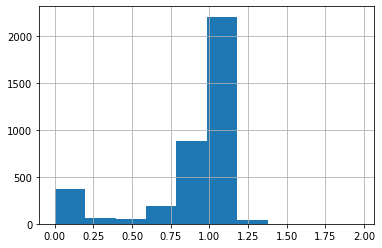

In [74]:
filtered_IPTW_table = IPTW_table[IPTW_table.IPTW < 2]
filtered_IPTW_table.IPTW.hist()

# MSM

In [76]:
cohort.shape 

(3820, 24)

In [85]:
IPTW_table.shape

(3820, 3)

In [86]:
PMF_table.shape

(20981, 7)

In [0]:
cohort_with_weight = cohort.merge(IPTW_table, left_index=True, right_index=True)

In [0]:
MSM_table = PMF_table.merge(cohort_with_weight, how = 'left' , on = ['subject_id', 'hadm_id', 'icustay_id'])

In [89]:
MSM_table.shape

(20981, 34)

In [92]:
MSM_table =  MSM_table[MSM_table.IPTW < 2]
MSM_table  #20981 without elimnating wights > 2 

,subject_id,hadm_id,icustay_id,pao2fio2,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality,nom,den,IPTW
0,10852,139654,253340,150.00000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.98524,0.943771,1.04394
1,10852,139654,253340,168.00000,0.0,0.0,0.0,23.60000,2127-04-27 13:00:00,2127-04-28 12:36:00,150.00000,11.0,62.0,NaT,3.3713,128.1,165.10,47.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,DIVORCED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,1,29,7,0,0,0,0.98524,0.943771,1.04394
2,27172,183106,209167,76.25000,0.0,0.0,0.0,155.00000,2111-09-06 01:00:00,2111-09-12 12:00:00,76.25000,12.0,55.0,NaT,16.8144,NaN,177.80,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA,0,54,17,1,1,0,0.737138,0.895453,0.823201
3,27172,183106,209167,NaN,0.0,0.0,0.0,155.00000,2111-09-06 01:00:00,2111-09-12 12:00:00,76.25000,12.0,55.0,NaT,16.8144,NaN,177.80,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA,0,54,17,1,1,0,0.737138,0.895453,0.823201
4,27172,183106,209167,NaN,0.0,0.0,0.0,155.00000,2111-09-06 01:00:00,2111-09-12 12:00:00,76.25000,12.0,55.0,NaT,16.8144,NaN,177.80,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA,0,54,17,1,1,0,0.737138,0.895453,0.823201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20976,42860,160594,219786,180.00000,0.0,0.0,0.0,5.48333,2113-01-23 19:00:00,2113-01-24 00:29:00,79.00000,5.0,62.0,NaT,1.2864,88.4,180.00,27.3,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,MITRAL VALVE STENOSIS; SHORTNESS OF BREATH\LEF...,0,33,0,0,1,0,0.951969,0.88172,1.07967
20977,6025,184173,233970,138.33333,0.0,0.0,0.0,5.86667,2109-12-13 12:00:00,2109-12-13 17:52:00,138.33333,5.0,83.0,NaT,12.4215,53.0,152.40,22.8,EMERGENCY,EMERGENCY ROOM ADMIT,None,CATHOLIC,None,WHITE,PERFORATED VISCUS,1,52,12,0,1,0,0.981777,0.960522,1.02213
20978,14858,191758,211210,123.00000,0.0,0.0,0.0,6.00000,2133-04-10 14:00:00,2133-04-10 20:00:00,123.00000,5.0,70.0,NaT,1.8278,81.6,157.48,32.9,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,None,CATHOLIC,SINGLE,WHITE,UNSTABLE ANGINA,1,51,0,0,1,0,0.975122,0.949496,1.02699
20979,84717,134774,234116,76.00000,0.0,0.0,0.0,2.00000,2104-09-21 05:00:00,2104-09-21 07:00:00,76.00000,5.0,77.0,2104-09-22,2.1108,41.3,NaN,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,1,52,10,1,1,1,0.976666,0.895059,1.09117


In [0]:
X = MSM_table[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'vaso']] # add sepsis and BMI
y = MSM_table['death_t']

# Instantiate a binomial family model with the logit function.
# MSM_model = sm.GLM(y, X, family=sm.families.Binomial(), links = sm.genmod.families.links.logit)
MSM_model = sm.GLM(y, X, family=sm.families.Binomial(),  links = sm.genmod.families.links.logit)

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                20981
Model:                            GLM   Df Residuals:                    20975
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3415.0
Date:                Thu, 12 Mar 2020   Deviance:                       6829.9
Time:                        13:10:46   Pearson chi2:                 3.25e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tr_t_min_1     0.3652      0.125      2.919      0.0

In [0]:
X = MSM_table[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'vaso']]
y = MSM_table['death_t']

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()

print(MSM_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death_t   No. Observations:                20981
Model:                            GLM   Df Residuals:                 15004.54
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2668.4
Date:                Thu, 12 Mar 2020   Deviance:                       5336.9
Time:                        13:10:46   Pearson chi2:                 2.22e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tr_t_min_1     1.8742      0.236      7.953      0.0

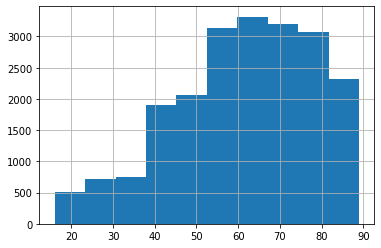

In [0]:
MSM_table.age.hist()

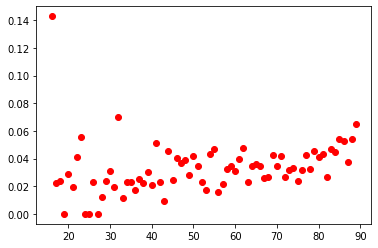

In [0]:
age_table = MSM_table.groupby(['age']).mean()
plt.plot(age_table.index, age_table.death_t, 'ro')

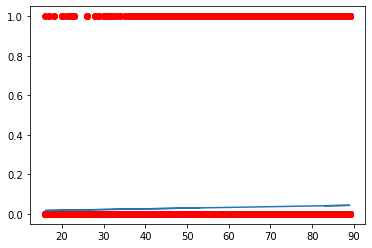

In [0]:
x = MSM_table.age
y = MSM_table.death_t
plt.plot(x, y, 'ro')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

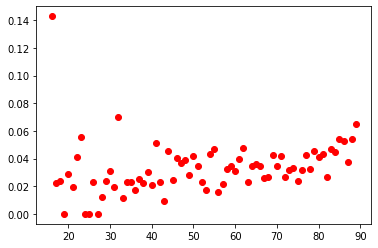

In [0]:
age_table = MSM_table.groupby(['age']).mean()
plt.plot(age_table.index, age_table.death_t, 'ro')

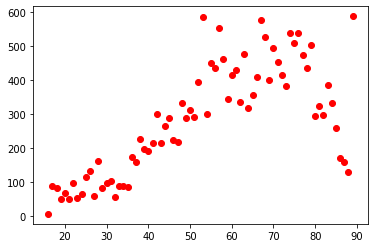

In [0]:
age_table = MSM_table.groupby(['age']).count() 
plt.plot(age_table.index, age_table.death_t, 'ro')

In [0]:
MSM_table[MSM_table.age > 85]

,subject_id,hadm_id,icustay_id,pao2fio2,tr_t_min_1,tr_t,death_t,mv_durations_hours,mv_starttime,mv_endtime,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,vaso,mortality,IPTW
18,24634,189519,258370,85.00000,0.0,0.0,0.0,292.75,2176-11-03 09:00:00,2176-11-15 13:45:00,85.0,10.0,89.0,2176-11-20,17.2926,80.0,168.91,28.0,EMERGENCY,EMERGENCY ROOM ADMIT,None,JEWISH,MARRIED,WHITE,GASTROINTESTINAL BLEED,0,45,0,1,1,0.889382
19,24634,189519,258370,171.66667,0.0,0.0,0.0,292.75,2176-11-03 09:00:00,2176-11-15 13:45:00,85.0,10.0,89.0,2176-11-20,17.2926,80.0,168.91,28.0,EMERGENCY,EMERGENCY ROOM ADMIT,None,JEWISH,MARRIED,WHITE,GASTROINTESTINAL BLEED,0,45,0,1,1,0.889382
20,24634,189519,258370,NaN,0.0,0.0,0.0,292.75,2176-11-03 09:00:00,2176-11-15 13:45:00,85.0,10.0,89.0,2176-11-20,17.2926,80.0,168.91,28.0,EMERGENCY,EMERGENCY ROOM ADMIT,None,JEWISH,MARRIED,WHITE,GASTROINTESTINAL BLEED,0,45,0,1,1,0.889382
21,24634,189519,258370,NaN,0.0,0.0,0.0,292.75,2176-11-03 09:00:00,2176-11-15 13:45:00,85.0,10.0,89.0,2176-11-20,17.2926,80.0,168.91,28.0,EMERGENCY,EMERGENCY ROOM ADMIT,None,JEWISH,MARRIED,WHITE,GASTROINTESTINAL BLEED,0,45,0,1,1,0.889382
22,24634,189519,258370,NaN,0.0,0.0,0.0,292.75,2176-11-03 09:00:00,2176-11-15 13:45:00,85.0,10.0,89.0,2176-11-20,17.2926,80.0,168.91,28.0,EMERGENCY,EMERGENCY ROOM ADMIT,None,JEWISH,MARRIED,WHITE,GASTROINTESTINAL BLEED,0,45,0,1,1,0.889382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20864,9253,171616,205299,292.00000,0.0,0.0,0.0,107.25,2142-04-24 03:00:00,2142-04-28 14:15:00,140.0,5.0,89.0,2147-09-29,7.7881,78.9,170.18,27.2,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,UNITARIAN-UNIVERSALIST,MARRIED,WHITE,PNEUMONIA,0,33,21,1,1,0.976655
20865,9253,171616,205299,140.00000,0.0,0.0,0.0,107.25,2142-04-24 03:00:00,2142-04-28 14:15:00,140.0,5.0,89.0,2147-09-29,7.7881,78.9,170.18,27.2,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,UNITARIAN-UNIVERSALIST,MARRIED,WHITE,PNEUMONIA,0,33,21,1,1,0.976655
20866,9253,171616,205299,NaN,0.0,0.0,0.0,107.25,2142-04-24 03:00:00,2142-04-28 14:15:00,140.0,5.0,89.0,2147-09-29,7.7881,78.9,170.18,27.2,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,UNITARIAN-UNIVERSALIST,MARRIED,WHITE,PNEUMONIA,0,33,21,1,1,0.976655
20867,9253,171616,205299,NaN,0.0,0.0,0.0,107.25,2142-04-24 03:00:00,2142-04-28 14:15:00,140.0,5.0,89.0,2147-09-29,7.7881,78.9,170.18,27.2,EMERGENCY,EMERGENCY ROOM ADMIT,ENGL,UNITARIAN-UNIVERSALIST,MARRIED,WHITE,PNEUMONIA,0,33,21,1,1,0.976655


In [0]:
from zepid import load_sample_data, spline, RiskDifference
from zepid.causal.gformula import TimeFixedGFormula, SurvivalGFormula
from zepid.causal.ipw import IPTW, IPMW
from zepid.causal.snm import GEstimationSNM
from zepid.causal.doublyrobust import AIPTW, TMLE

df = load_sample_data(timevary=False)
df = df.drop(columns=['cd4_wk45'])
df

,id,male,age0,cd40,dvl0,art,dead,t
0,2,1,51,440,1,0,1.0,32.043
1,3,1,21,219,0,0,0.0,45.000
2,5,1,18,460,0,0,0.0,45.000
3,6,1,34,470,1,0,0.0,45.000
4,7,1,29,361,0,0,0.0,45.000
...,...,...,...,...,...,...,...,...
542,795,0,20,494,1,0,0.0,45.000
543,796,1,33,458,1,0,0.0,45.000
544,798,1,32,237,1,0,0.0,45.000
545,799,1,44,488,1,0,0.0,45.000


In [0]:

df[['cd4_rs1', 'cd4_rs2']] = spline(df, 'cd40', n_knots=3, term=2, restricted=True)
df[['age_rs1', 'age_rs2']] = spline(df, 'age0', n_knots=3, term=2, restricted=True)
df

,id,male,age0,cd40,dvl0,art,dead,t,cd4_rs1,cd4_rs2,age_rs1,age_rs2
0,2,1,51,440,1,0,1.0,32.043,172640.25,12996.0,823.69,144.0
1,3,1,21,219,0,0,0.0,45.000,37830.25,0.0,0.00,0.0
2,5,1,18,460,0,0,0.0,45.000,189660.25,17956.0,0.00,0.0
3,6,1,34,470,1,0,0.0,45.000,198470.25,20736.0,136.89,0.0
4,7,1,29,361,0,0,0.0,45.000,113232.25,1225.0,44.89,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
542,795,0,20,494,1,0,0.0,45.000,220286.25,28080.0,0.00,0.0
543,796,1,33,458,1,0,0.0,45.000,187922.25,17424.0,114.49,0.0
544,798,1,32,237,1,0,0.0,45.000,45156.25,0.0,94.09,0.0
545,799,1,44,488,1,0,0.0,45.000,214796.25,26208.0,470.89,25.0


In [0]:
iptw = IPTW(df, treatment='art', outcome = 'dead')

In [0]:
 iptw.treatment_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                     print_results=True)


----------------------------------------------------------------
MODEL: art ~ male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0
-----------------------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    art   No. Observations:                  547
Model:                            GLM   Df Residuals:                      538
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -214.63
Date:                Thu, 12 Mar 2020   Deviance:                       429.26
Time:                        13:10:48   Pearson chi2:                     539.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         

In [0]:
iptw.marginal_structural_model('art')
iptw.fit()
iptw.summary()

/usr/local/lib/python3.6/dist-packages/zepid/causal/ipw/IPTW.py:355: UserWarning: All missing outcome data is assumed to be missing completely at random. To relax this assumption to outcome data is missing at random please use the `missing_model()` function
  "function", UserWarning)


              Inverse Probability of Treatment Weights                
Treatment:        art             No. Observations:     547                 
Outcome:          dead            No. Missing Outcome:  30                  
g-Model:          Logistic        Missing Model:        None                
Risk Difference
----------------------------------------------------------------------
              RD  SE(RD)  95%LCL  95%UCL
labels                                  
Intercept  0.182   0.019   0.145   0.218
art       -0.082   0.038  -0.156  -0.007
----------------------------------------------------------------------
Risk Ratio
              RR  SE(log(RR))  95%LCL  95%UCL
labels                                       
Intercept  0.182        0.103   0.148   0.222
art        0.551        0.347   0.279   1.088
----------------------------------------------------------------------
Odds Ratio
              OR  SE(log(OR))  95%LCL  95%UCL
labels                                       
Interce

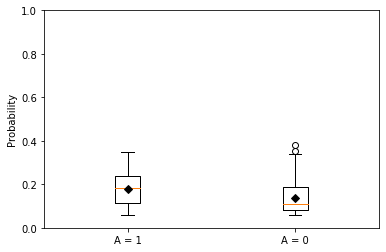

In [0]:
iptw.plot_boxplot()

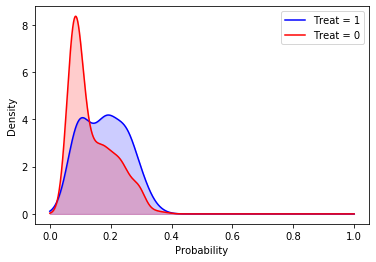

In [0]:
iptw.plot_kde()

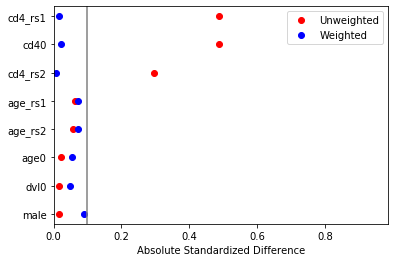

In [0]:
iptw.plot_love()

In [0]:
t = np.array([1, 1, 0, 0])
p = np.array([0.1 , 0.2 , 0.3, 0.4])
np.where(t == 1 , p, 1 - p)

array([0.1, 0.2, 0.7, 0.6])